# Gradiente e Classificação multinomial

Nícolas Hecker Silva RA 186132


## Descrição 

Esta tarefa explora conceitos de c ́alculo vetorial, otimiza ̧c ̃ao e m ́etodos de gradiente descendente no contexto de aprendizado de m ́aquina, com foco em classifica ̧c ̃ao multinomial.

## Etapa 1: Funções Convexas e Otimização

Dado uma função $f(x) = x^TAx + b^Tx + c$ faça três versões mudando a matriz A para que a função seja:


- Fortemente Convexa.
- Convexa.
- Não Convexa.

Evidencia cada uma das propriedades.


Dado o enunciado acima, como não foram especificados os tipos das variáveis e constantes será assumido que:
x: É um vetor coluna de dimensão n (nx1)
A: É uma matriz quadrada de dimensão nxn
b: É um vetor coluna de dimensão n (nx1)
c: É um escalar

Dessa forma a dimensão das parcelas será:

$x^TAx = (nx1)^T * (nxn) * (nx1) = (1xn) * (nxn) * (nx1) = (1)$

$b^Tx = (nx1)^T * (nx1) = (1xn) * (nx1) = (1)$

$c = (1)$

Dessa forma f(x) retornará um valor real.

Uma função $ f: \mathbb{R}^n \to \mathbb{R} $ é **fortemente convexa** com parâmetro $ m > 0 $ se, para todo $ x, y \in \mathbb{R}^n $, satisfizer:

$
f(x) \geq f(y) + \nabla f(y)^T (x - y) + \frac{m}{2} \| x - y \|^2.
$

Se $ f(x) = x^T A x + b^T x + c $, para que $ f $ seja fortemente convexa, a matriz $ A $ deve ser **positiva definida** com todos os autovalores maiores ou iguais a $ m $, ou seja, $ \lambda_{\min}(A) \geq m > 0 $.

Por fim, basta que o menor autovalor de $A$ seja maior que 0, sendo (novamente) **positiva definida**. E para isso, basta ela ser simétrica. Uma matriz exemplo seria

$$
A = \begin{pmatrix}
  2 & 0 \\
  0 & 3 
\end{pmatrix}
$$

cujos autovalores são exatamente 2 e 3.

Já para a função ser **convexa** basta que seus autovalores sejam não negativos, ou seja, eles podem ser nulos. Dessa forma, a matriz exemplo

$$
A = \begin{pmatrix}
  2 & 0 \\
  0 & 0
\end{pmatrix}
$$

terá os autovalores 0 e 2, fazendo com que f(x) seja **convexa**.

Dessa forma, para que a função f seja **não convexa**, é necessário que algum autovalor seja negativo, pois nesse caso a função f(x) não terá curvatura positiva em todas as direções, podendo curvar-se para baixo em algumas direções, o que viola a convexidade.

Um exemplo é a matriz

$$
A = \begin{pmatrix}
  2 & 0 \\
  0 & -1
\end{pmatrix}
$$

em que os autovalores são 2 e -1, sendo -1 um valor negativo fazendo com que A não seja semidefinida positiva.



In [1]:
!python -m pip install tqdm
!python -m pip install torch
!python -m pip install matplotlib
!python -m pip install numpy

import os
import numpy as np
import struct
from array import array
from os.path  import join
from tqdm import tqdm
from time import time


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


Uma primeira parte muito importante é baixar o dataset mnist. Ele será baixado usando o comando shell curl e será colocado na pasta dataset-t3

In [2]:
# cria pasta dataset-t3
os.makedirs('dataset-t3', exist_ok=True)

if not os.path.exists('dataset-t3/d.zip'):
    !curl -L -o dataset-t3/d.zip\
    https://www.kaggle.com/api/v1/datasets/download/hojjatk/mnist-dataset
    !unzip dataset-t3/d.zip -d dataset-t3

Para verificar as imagens (uma vez q a extensão delas não é visível), vamos usar o código fornecido pelos autores do MNIST no kaggle (duas células abaixo)

In [3]:
#
# MNIST Data Loader Class
#
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)   

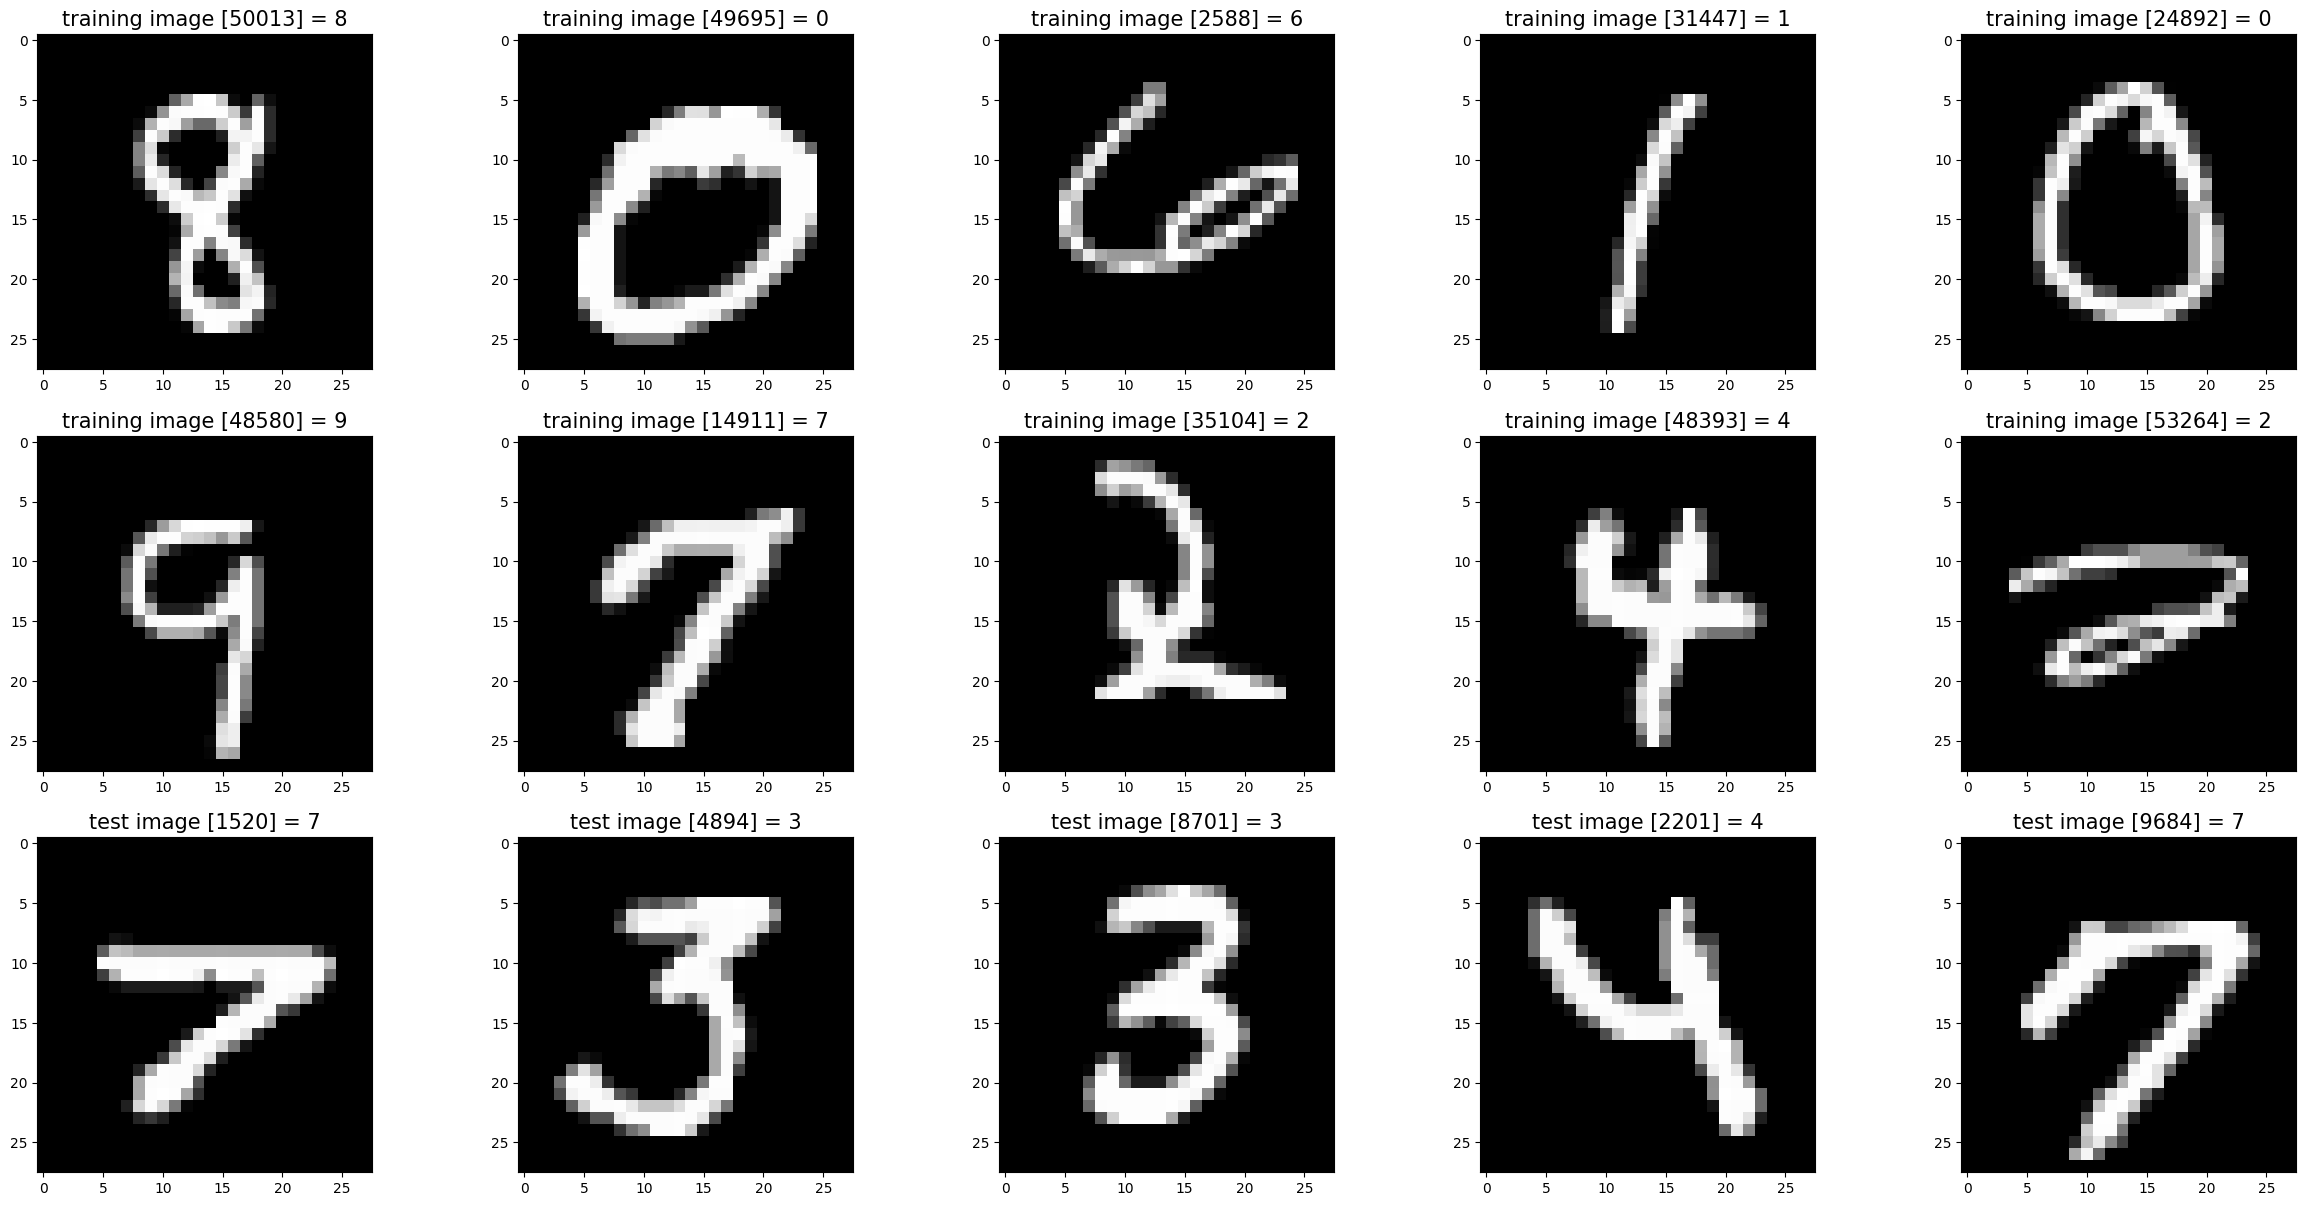

In [4]:
#
# Verify Reading Dataset via MnistDataloader class
#
%matplotlib inline
import random
import matplotlib.pyplot as plt

#
# Set file paths based on added MNIST Datasets
#
input_path = 'dataset-t3'
training_images_filepath = join(input_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

#
# Helper function to show a list of images with their relating titles
#
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1

#
# Load MINST dataset
#
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

#
# Show some random training and test images 
#
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))    

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))    

show_images(images_2_show, titles_2_show)

In [5]:
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)



print('x_train.shape =', x_train.shape)
print('y_train.shape =', np.array(y_train).shape)

x_train.shape = (60000, 28, 28)
y_train.shape = (60000,)


In [6]:
raise Exception("Stop here")

Exception: Stop here

In [ ]:
def acuracia(y_true, y_pred):
    return np.mean(y_true == y_pred)

# Função softmax para calcular probabilidades
def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))  # Evitar overflow numérico
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

# Gradiente descendente para treinar o modelo
def train(X, y, n_classes, learning_rate=0.1, n_iter=1000):
    X = X.reshape(X.shape[0], -1)
    n_samples, n_features,  = X.shape
    W = np.random.rand(n_features, n_classes)
    b = np.zeros((1, n_classes))

    tempos = {"logits": 0, "softmax": 0, "pred": 0, "grads": 0, "update": 0}
    for i in tqdm(range(n_iter)):
        # Cálculo de logits e probabilidades
        medidor = time()
        logits = np.dot(X, W) + b
        tempos["logits"] += time() - medidor

        medidor = time()
        y_pred = softmax(logits)
        tempos["softmax"] += time() - medidor

        medidor = time()
        pred = np.argmax(y_pred, axis=1)
        tempos["pred"] += time() - medidor

        medidor = time()
        # Calcular e atualizar os gradientes
        y_one_hot = np.eye(n_classes)[y]
        grad_W = (1 / n_samples) * np.dot(X.T, (y_pred - y_one_hot))
        grad_b = (1 / n_samples) * np.sum(y_pred - y_one_hot, axis=0, keepdims=True)
        tempos["grads"] += time() - medidor

        medidor = time()
        W -= learning_rate * grad_W
        b -= learning_rate * grad_b
        tempos["update"] += time() - medidor

        if i % (n_iter//10) == 0:
            print(f"Iteração {i}, acurácia: {acuracia(y, pred) * 100:.2f}%")
            print("Tempos: {}".format(tempos))
    print(f"Iteração {n_iter}, acurácia: {acuracia(y, pred) * 100:.2f}%")

    return W, b

# Prever as classes
def predict(X, W, b):
    X = X.reshape(X.shape[0], -1)
    logits = np.dot(X, W) + b
    y_pred = softmax(logits)
    return np.argmax(y_pred, axis=1)


X, y = x_train, y_train
n_classes = len(np.unique(y))

# Treinamento
W, b = train(X, y, n_classes, n_iter = 500, learning_rate=0.002)

# Previsão e avaliação
y_pred = predict(x_test, W, b)
accuracy = np.mean(y_pred == y_test)
print(f"Acurácia do modelo no teste: {accuracy * 100:.2f}%")


  0%|          | 1/500 [00:00<01:47,  4.63it/s]

Iteração 0, acurácia: 14.66%
Tempos: {'logits': 0.09848451614379883, 'softmax': 0.015467405319213867, 'pred': 0.004022121429443359, 'grads': 0.09780597686767578, 'update': 2.86102294921875e-05}


 10%|█         | 51/500 [00:11<01:44,  4.29it/s]

Iteração 50, acurácia: 78.39%
Tempos: {'logits': 5.463601350784302, 'softmax': 1.0775504112243652, 'pred': 0.14612650871276855, 'grads': 4.883233070373535, 'update': 0.0014452934265136719}


 20%|██        | 101/500 [00:23<01:39,  4.00it/s]

Iteração 100, acurácia: 82.60%
Tempos: {'logits': 10.98532223701477, 'softmax': 2.167076587677002, 'pred': 0.28975844383239746, 'grads': 9.8349130153656, 'update': 0.0028891563415527344}


 30%|███       | 151/500 [00:34<01:22,  4.23it/s]

Iteração 150, acurácia: 84.24%
Tempos: {'logits': 16.414186716079712, 'softmax': 3.238192081451416, 'pred': 0.4279928207397461, 'grads': 14.697157144546509, 'update': 0.004314899444580078}


 40%|████      | 201/500 [00:46<01:08,  4.36it/s]

Iteração 200, acurácia: 85.23%
Tempos: {'logits': 21.899707794189453, 'softmax': 4.317267894744873, 'pred': 0.5675678253173828, 'grads': 19.662281036376953, 'update': 0.0057871341705322266}


 50%|█████     | 251/500 [01:00<01:16,  3.24it/s]

Iteração 250, acurácia: 85.78%
Tempos: {'logits': 28.416506052017212, 'softmax': 5.67357873916626, 'pred': 0.7294960021972656, 'grads': 25.739469289779663, 'update': 0.00731968879699707}


 60%|██████    | 301/500 [01:15<00:51,  3.86it/s]

Iteração 300, acurácia: 86.29%
Tempos: {'logits': 34.88772010803223, 'softmax': 6.987093925476074, 'pred': 0.9091517925262451, 'grads': 31.824959993362427, 'update': 0.009133100509643555}


 70%|███████   | 351/500 [01:29<00:46,  3.22it/s]

Iteração 350, acurácia: 86.49%
Tempos: {'logits': 41.566516637802124, 'softmax': 8.208101511001587, 'pred': 1.0596375465393066, 'grads': 37.89609217643738, 'update': 0.01075601577758789}


 80%|████████  | 401/500 [01:44<00:27,  3.54it/s]

Iteração 400, acurácia: 86.87%
Tempos: {'logits': 48.68311357498169, 'softmax': 9.426937103271484, 'pred': 1.2286968231201172, 'grads': 44.12649965286255, 'update': 0.012527227401733398}


 90%|█████████ | 451/500 [01:58<00:13,  3.67it/s]

Iteração 450, acurácia: 87.22%
Tempos: {'logits': 55.45936894416809, 'softmax': 10.60566759109497, 'pred': 1.3734054565429688, 'grads': 50.06686997413635, 'update': 0.01423192024230957}


100%|██████████| 500/500 [02:12<00:00,  3.79it/s]

Iteração 500, acurácia: 87.37%
Acurácia do modelo no teste: 87.37%


In [ ]:
from random import randint

# Função para treinamento com SGD
def train_SGD(X, y, n_classes, learning_rate=0.1, n_iter=1000, batch_size=1):
    X = X.reshape(X.shape[0], -1)
    n_samples, n_features = X.shape
    W = np.random.rand(n_features, n_classes)
    b = np.zeros((1, n_classes))

    num_batches = n_samples // batch_size
    for i in tqdm(range(n_iter)):
        # Em SGD, iteramos por amostras ou mini-lotes

        # sorteia um índice de batch
        idx = randint(0,num_batches)
        # Selecionar uma amostra ou mini-lote
        X_batch = X[idx*batch_size:idx*batch_size + batch_size]
        y_batch = y[idx*batch_size:idx*batch_size + batch_size]
        
        # Cálculo de logits e probabilidades
        logits = np.dot(X_batch, W) + b
        y_pred = softmax(logits)
        pred = np.argmax(y_pred, axis=1)
        
        # Calcular os gradientes para essa amostra ou mini-lote
        y_one_hot = np.eye(n_classes)[y_batch]
        grad_W = (1 / batch_size) * np.dot(X_batch.T, (y_pred - y_one_hot))
        grad_b = (1 / batch_size) * np.sum(y_pred - y_one_hot, axis=0, keepdims=True)
        
        # Atualizar os pesos e o viés com base nos gradientes
        W -= learning_rate * grad_W
        b -= learning_rate * grad_b
        
        # A cada 5 iterações, printa a acurácia
        if i % (n_iter//10) == 0:
            pred = np.argmax(softmax(np.dot(X, W) + b), axis=1)
            print(f"Iteração {i}, acurácia: {acuracia(y, pred) * 100:.2f}%")
    
    # Final
    pred = np.argmax(softmax(np.dot(X, W) + b), axis=1)
    print(f"Iteração {n_iter}, acurácia: {acuracia(y, pred) * 100:.2f}%")

    return W, b

# Função para prever as classes
def predict(X, W, b):
    X = X.reshape(X.shape[0], -1)
    logits = np.dot(X, W) + b
    y_pred = softmax(logits)
    return np.argmax(y_pred, axis=1)

# Treinamento usando SGD
W, b = train_SGD(X, y, n_classes, learning_rate=0.002, n_iter=1000000, batch_size=1)

# Previsão e avaliação
y_pred = predict(x_test, W, b)
accuracy = np.mean(y_pred == y_test)
print(f"Acurácia do modelo no teste: {accuracy * 100:.2f}%")


  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 3039/1000000 [00:00<01:33, 10699.49it/s]

Iteração 0, acurácia: 10.27%


 10%|█         | 103415/1000000 [00:05<00:58, 15380.08it/s]

Iteração 100000, acurácia: 89.31%


 20%|██        | 203372/1000000 [00:10<00:53, 14804.16it/s]

Iteração 200000, acurácia: 85.76%


 30%|███       | 301583/1000000 [00:16<00:52, 13370.08it/s]

Iteração 300000, acurácia: 88.20%


 40%|████      | 403355/1000000 [00:21<00:41, 14375.60it/s]

Iteração 400000, acurácia: 88.97%


 50%|█████     | 503295/1000000 [00:26<00:32, 15165.13it/s]

Iteração 500000, acurácia: 89.19%


 60%|██████    | 603415/1000000 [00:31<00:26, 14928.60it/s]

Iteração 600000, acurácia: 89.09%


 70%|███████   | 703195/1000000 [00:36<00:21, 13937.43it/s]

Iteração 700000, acurácia: 89.99%


 80%|████████  | 802426/1000000 [00:42<00:13, 14183.43it/s]

Iteração 800000, acurácia: 90.09%


 90%|█████████ | 901994/1000000 [00:47<00:06, 14842.17it/s]

Iteração 900000, acurácia: 90.35%


100%|██████████| 1000000/1000000 [00:51<00:00, 19263.29it/s]


Iteração 1000000, acurácia: 88.94%
Acurácia do modelo no teste: 88.40%


In [ ]:
from random import randint

# Função para treinamento com SGD
def train_SGD(X, y, n_classes, learning_rate=0.1, n_iter=1000, batch_size=1):
    X = X.reshape(X.shape[0], -1)
    n_samples, n_features = X.shape
    W = np.random.rand(n_features, n_classes)
    b = np.zeros((1, n_classes))

    num_batches = n_samples // batch_size
    for i in tqdm(range(n_iter)):
        # Em SGD, iteramos por amostras ou mini-lotes

        # sorteia um índice de batch
        idx = randint(0,num_batches)
        # Selecionar uma amostra ou mini-lote
        X_batch = X[idx*batch_size:idx*batch_size + batch_size]
        y_batch = y[idx*batch_size:idx*batch_size + batch_size]
        
        # Cálculo de logits e probabilidades
        logits = np.dot(X_batch, W) + b
        y_pred = softmax(logits)
        pred = np.argmax(y_pred, axis=1)
        
        # Calcular os gradientes para essa amostra ou mini-lote
        y_one_hot = np.eye(n_classes)[y_batch]
        grad_W = (1 / batch_size) * np.dot(X_batch.T, (y_pred - y_one_hot))
        grad_b = (1 / batch_size) * np.sum(y_pred - y_one_hot, axis=0, keepdims=True)
        
        # Atualizar os pesos e o viés com base nos gradientes
        W -= learning_rate * grad_W
        b -= learning_rate * grad_b
        
        # A cada 5 iterações, printa a acurácia
        if i % (n_iter//10) == 0:
            pred = np.argmax(softmax(np.dot(X, W) + b), axis=1)
            print(f"Iteração {i}, acurácia: {acuracia(y, pred) * 100:.2f}%")
    
    # Final
    pred = np.argmax(softmax(np.dot(X, W) + b), axis=1)
    print(f"Iteração {n_iter}, acurácia: {acuracia(y, pred) * 100:.2f}%")

    return W, b

# Função para prever as classes
def predict(X, W, b):
    X = X.reshape(X.shape[0], -1)
    logits = np.dot(X, W) + b
    y_pred = softmax(logits)
    return np.argmax(y_pred, axis=1)

# Treinamento usando SGD
W, b = train_SGD(X, y, n_classes, learning_rate=0.0001, n_iter=100000, batch_size=100)

# Previsão e avaliação
y_pred = predict(x_test, W, b)
accuracy = np.mean(y_pred == y_test)
print(f"Acurácia do modelo no teste: {accuracy * 100:.2f}%")


  0%|          | 224/100000 [00:00<01:33, 1065.61it/s]

Iteração 0, acurácia: 7.09%


 10%|█         | 10270/100000 [00:03<00:37, 2377.61it/s]

Iteração 10000, acurácia: 87.20%


 20%|██        | 20281/100000 [00:07<00:39, 2024.73it/s]

Iteração 20000, acurácia: 88.32%


 30%|███       | 30272/100000 [00:10<00:32, 2164.63it/s]

Iteração 30000, acurácia: 88.89%


 40%|████      | 40268/100000 [00:14<00:28, 2094.46it/s]

Iteração 40000, acurácia: 89.06%


 50%|█████     | 50319/100000 [00:18<00:22, 2176.02it/s]

Iteração 50000, acurácia: 89.29%


 60%|██████    | 60327/100000 [00:21<00:18, 2115.74it/s]

Iteração 60000, acurácia: 89.59%


 70%|███████   | 70263/100000 [00:25<00:15, 1958.49it/s]

Iteração 70000, acurácia: 90.00%


 80%|████████  | 80395/100000 [00:29<00:09, 2145.21it/s]

Iteração 80000, acurácia: 89.97%


 91%|█████████ | 90553/100000 [00:32<00:03, 2542.34it/s]

Iteração 90000, acurácia: 90.11%


100%|██████████| 100000/100000 [00:35<00:00, 2821.27it/s]


Iteração 100000, acurácia: 90.10%
Acurácia do modelo no teste: 88.65%


In [ ]:
# redressão logistica do pytorch
import torch

# Carregar os dados
X_train = torch.tensor(x_train.reshape(x_train.shape[0], -1), dtype=torch.float32)
y_train = torch.tensor(y_train.reshape(y_train.shape[0], -1), dtype=torch.int64)
X_test = torch.tensor(x_test.reshape(x_test.shape[0], -1), dtype=torch.float32)
y_test = torch.tensor(y_test.reshape(y_test.shape[0], -1), dtype=torch.int64)

# Definir o modelo
model = torch.nn.Linear(28*28, 10)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

# Treinamento
for i in range(10):
    model.train()
    optimizer.zero_grad()
    y_pred = model(X_train)


    y_train_one_hot = torch.nn.functional.one_hot(y_train, 10).float()

    # remove dimensão vazia do meio
    y_train_one_hot = y_train_one_hot.squeeze(1)
    print(y_pred.shape, y_train_one_hot.shape)

    loss = loss_fn(y_pred, y_train_one_hot)
    loss.backward()
    optimizer.step()
    
    if i % 2 == 0:
        model.eval()
        y_pred = model(X_train)
        acc = torch.mean((torch.argmax(y_pred, dim=1) == y_train).float())
        print(f"Iteração {i}, acurácia: {acc * 100:.2f}%")

    # zera a loss
    loss = 0

# Avaliação
model.eval()
y_pred = model(X_test)
acc = torch.mean((torch.argmax(y_pred, dim=1) == y_test).float())
print(f"Acurácia do modelo no teste: {acc * 100:.2f}%")


torch.Size([60000, 10]) torch.Size([60000, 10])
